In [1]:
import numpy as np
import os
import sys
import math

# ----- class for snapshot header ----- 

class snapshot_header:
    def __init__(self, filename):
        if (not os.path.exists(filename)):
            print("file not found:", filename)
            sys.exit()
      
        self.filename = filename  
        f = open(filename,'rb')    
        blocksize = np.fromfile(f,dtype=np.int32,count=1)
        if blocksize[0] == 8:
            swap = 0
            format = 2
        elif blocksize[0] == 256:
            swap = 0
            format = 1  
        else:
            blocksize.byteswap(True)
            if blocksize[0] == 8:
                swap = 1
                format = 2
            elif blocksize[0] == 256:
                swap = 1
                format = 1
            else:
                print("incorrect file format encountered when reading header of", filename)
                sys.exit()
    
        self.format = format
        self.swap = swap
    
        if format==2:
            f.seek(16, os.SEEK_CUR)
    
        self.npart = np.fromfile(f,dtype=np.int32,count=6)
        self.massarr = np.fromfile(f,dtype=np.float64,count=6)
        self.time = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.redshift = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.sfr = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.feedback = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.nall = np.fromfile(f,dtype=np.int32,count=6)
        self.cooling = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.filenum = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.boxsize = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.omega_m = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.omega_l = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.hubble = (np.fromfile(f,dtype=np.float64,count=1))[0]
    
        if swap:
            self.npart.byteswap(True)
            self.massarr.byteswap(True)
            self.time = self.time.byteswap()
            self.redshift = self.redshift.byteswap()
            self.sfr = self.sfr.byteswap()
            self.feedback = self.feedback.byteswap()
            self.nall.byteswap(True)
            self.cooling = self.cooling.byteswap()
            self.filenum = self.filenum.byteswap()
            self.boxsize = self.boxsize.byteswap()
            self.omega_m = self.omega_m.byteswap()
            self.omega_l = self.omega_l.byteswap()
            self.hubble = self.hubble.byteswap()
     
        f.close()
 


#----- find offset and size of data block ----- 

def find_block(filename, format, swap, block, block_num, only_list_blocks=False):
    if (not os.path.exists(filename)):
        print("file not found:", filename)
        sys.exit()
            
    f = open(filename,'rb')
    f.seek(0, os.SEEK_END)
    filesize = f.tell()
    f.seek(0, os.SEEK_SET)
  
    found = False
    curblock_num = 1
    while ((not found) and (f.tell()<filesize)):
        if format==2:
            f.seek(4, os.SEEK_CUR)
            curblock = f.read(4)
            if (block == curblock):
                found = True
            f.seek(8, os.SEEK_CUR)  
        else:
            if curblock_num==block_num:
                found = True
        
        curblocksize = (np.fromfile(f,dtype=np.int32,count=1))[0]
        if swap:
            curblocksize = curblocksize.byteswap()
    
    # - print some debug info about found data blocks -
    #if format==2:
    #  print curblock, curblock_num, curblocksize
    #else:
    #  print curblock_num, curblocksize
    
        if only_list_blocks:
            print(curblock_num,curblock,f.tell(),curblocksize)
            found = False
    
        if found:
            blocksize = curblocksize
            offset = f.tell()
        else:
            f.seek(curblocksize, os.SEEK_CUR)
            blocksize_check = (np.fromfile(f,dtype=np.int32,count=1))[0]
            if swap: blocksize_check = blocksize_check.byteswap()
            if (curblocksize != blocksize_check):
                print("something wrong")
                sys.exit()
            curblock_num += 1
      
    f.close()
      
    if ((not found) and (not only_list_blocks)):
        print("Error: block not found")
        sys.exit()
    
    if (not only_list_blocks):
        return offset,blocksize
 
# ----- read data block -----
 
def read_block(filename, block, parttype=-1, physical_velocities=True, arepo=0, no_masses=False, verbose=False):
    if (verbose):
	    print("reading block", block)
  
    blockadd=0
    blocksub=0
  
    if arepo==0:
        if (verbose):	
	        print("Gadget format")
        blockadd=0
    if arepo==1:
        if (verbose):	
	        print("Arepo format")
        blockadd=1	
    if arepo==2:
        if (verbose):
	        print("Arepo extended format")
        blockadd=4	
    if no_masses==True:
        if (verbose):	
	        print("No mass block present")    
        blocksub=1
		 
    if parttype not in [-1,0,1,2,3,4,5]:
        print("wrong parttype given")
        sys.exit()
  
    if os.path.exists(filename):
        curfilename = filename
    elif os.path.exists(filename+".0"):
        curfilename = filename+".0"
    else:
        print("file not found:", filename)
        print("and:", curfilename)
        sys.exit()
  
    head = snapshot_header(curfilename)
    format = head.format
    swap = head.swap
    npart = head.npart
    massarr = head.massarr
    nall = head.nall
    filenum = head.filenum
    redshift = head.redshift
    time = head.time
    del head
  
  # - description of data blocks -
  # add or change blocks as needed for your Gadget version
    data_for_type = np.zeros(6,bool) # should be set to "True" below for the species for which data is stored in the data block
    dt = np.float32 # data type of the data in the block
    if block=="POS ":
        data_for_type[:] = True
        dt = np.dtype((np.float32,3))
        block_num = 2
    elif block=="VEL ":
        data_for_type[:] = True
        dt = np.dtype((np.float32,3))
        block_num = 3
    elif block=="ID  ":
        data_for_type[:] = True
        dt = np.uint32
        block_num = 4
    elif block=="MASS":
        data_for_type[np.where(massarr==0)] = True
        block_num = 5
        if parttype>=0 and massarr[parttype]>0:   
            if (verbose):	
	            print("filling masses according to massarr")   
            return np.ones(nall[parttype],dtype=dt)*massarr[parttype]
    elif block=="U   ":
        data_for_type[:] = True
        dt = np.dtype((np.float32))
        block_num = 6#-blocksub
    elif block=="RHO ":
        data_for_type[0] = True
        block_num = 7-blocksub
    elif block=="VOL ":
        data_for_type[0] = True
        block_num = 8-blocksub 
    elif block=="CMCE":
        data_for_type[0] = True
        dt = np.dtype((np.float32,3))
        block_num = 9-blocksub 
    elif block=="AREA":
        data_for_type[0] = True
        block_num = 10-blocksub
    elif block=="NFAC":
        data_for_type[0] = True
        dt = np.dtype(np.int32)	
        block_num = 11-blocksub
    elif block=="NE  ":
        data_for_type[0] = True
        block_num = 8+blockadd-blocksub
    elif block=="NH  ":
        data_for_type[0] = True
        block_num = 9+blockadd-blocksub
    elif block=="HSML":
        data_for_type[0] = True
        block_num = 10+blockadd-blocksub
    elif block=="SFR ":
        data_for_type[0] = True
        block_num = 11+blockadd-blocksub
    elif block=="AGE ":
        data_for_type[4] = True
        block_num = 12+blockadd-blocksub
    elif block=="Z   ":
        data_for_type[0] = True
        data_for_type[4] = True
        block_num = 13+blockadd-blocksub
    elif block=="BHMA":
        data_for_type[5] = True
        block_num = 14+blockadd-blocksub
    elif block=="BHMD":
        data_for_type[5] = True
        block_num = 15+blockadd-blocksub
    elif block=="COOR":
        data_for_type[0] = True
        block_num = -1 
    else:
        print("Sorry! Block type", block, "not known!")
        sys.exit()
  # - end of block description -

    if (block_num < 0 and format==1):
        print("Sorry! Block number of", block, "not known! Unable to read this block from format 1 file!")
        sys.exit() 
    
    actual_data_for_type = np.copy(data_for_type)  
    if parttype >= 0:
        actual_data_for_type[:] = False
        actual_data_for_type[parttype] = True
        if data_for_type[parttype]==False:
            print("Error: no data for specified particle type", parttype, "in the block", block)   
            sys.exit()
    elif block=="MASS":
        actual_data_for_type[:] = True  
    
    allpartnum = np.int64(0)
    species_offset = np.zeros(6,np.int64)
    for j in range(6):
        species_offset[j] = allpartnum
        if actual_data_for_type[j]:
            allpartnum += nall[j]
    filenum=1  
    for i in range(filenum): # main loop over files
        if filenum>1:
            curfilename = filename+"."+str(i)
      
        if i>0:
            head = snapshot_header(curfilename)
            npart = head.npart  
            del head
      
        curpartnum = np.int32(0)
        cur_species_offset = np.zeros(6,np.int64)
        for j in range(6):
            cur_species_offset[j] = curpartnum
            if data_for_type[j]:
                curpartnum += npart[j]
    
        if parttype>=0:
            actual_curpartnum = npart[parttype]      
            add_offset = cur_species_offset[parttype] 
        else:
            actual_curpartnum = curpartnum
            add_offset = np.int32(0)
      
        offset,blocksize = find_block(curfilename,format,swap,block,block_num)
    
        if i==0: # fix data type for ID if long IDs are used
            if block=="ID  ":
                if blocksize == np.dtype(dt).itemsize*curpartnum * 2:
                    dt = np.uint64 
        
        if np.dtype(dt).itemsize*curpartnum != blocksize:
            print("something wrong with blocksize! expected =",np.dtype(dt).itemsize*curpartnum,"actual =",blocksize)
            sys.exit()
    
        f = open(curfilename,'rb')
        f.seek(offset + add_offset*np.dtype(dt).itemsize, os.SEEK_CUR)  
        curdat = np.fromfile(f,dtype=dt,count=actual_curpartnum) # read data
        f.close()  
        if swap:
            curdat.byteswap(True)  
      
        if i==0:
            data = np.empty(allpartnum,dt)
    
        for j in range(6):
            if actual_data_for_type[j]:
                if block=="MASS" and massarr[j]>0: # add mass block for particles for which the mass is specified in the snapshot header
                    data[species_offset[j]:species_offset[j]+npart[j]] = massarr[j]
                else:
                    if parttype>=0:
                        data[species_offset[j]:species_offset[j]+npart[j]] = curdat
                    else:
                        data[species_offset[j]:species_offset[j]+npart[j]] = curdat[cur_species_offset[j]:cur_species_offset[j]+npart[j]]
                species_offset[j] += npart[j]

        del curdat

    if physical_velocities and block=="VEL " and redshift!=0:
        data *= math.sqrt(time)

    return data
  
# ----- list all data blocks in a format 2 snapshot file -----

def list_format2_blocks(filename):
    if (not os.path.exists(filename)):
        print("file not found:", filename)
        sys.exit()
  
    head = snapshot_header(filename)
    format = head.format
    swap = head.swap
    del head
  
    if (format != 2):
        print("not a format 2 snapshot file")
        sys.exit()
            
    print("#   BLOCK   OFFSET   SIZE")
    print("-------------------------")
  
    find_block(filename, format, swap, "XXXX", 0, only_list_blocks=True)
  
    print("-------------------------")


In [2]:
dm_mass_600 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_600","MASS",parttype=1)
dm_pos_600 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_600","POS ",parttype=1)
dm_vel_600 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_600","VEL ",parttype=1)

disk_mass_600 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_600","MASS",parttype=2)
disk_pos_600 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_600","POS ",parttype=2)
disk_vel_600 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_600","VEL ",parttype=2)

bulg_mass_600 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_600","MASS",parttype=3)
bulg_pos_600 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_600","POS ",parttype=3)
bulg_vel_600 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_600","VEL ",parttype=3)


In [3]:
dm_mass_600 = dm_mass_600 * 10**10
disk_mass_600 = disk_mass_600 * 10**10
bulg_mass_600 = bulg_mass_600 * 10**10

X_dm_600 = dm_pos_600[:,0]
Y_dm_600 = dm_pos_600[:,1]
Z_dm_600 = dm_pos_600[:,2]

X_disk_600 = disk_pos_600[:,0]
Y_disk_600 = disk_pos_600[:,1]
Z_disk_600 = disk_pos_600[:,2]

X_bulg_600 = bulg_pos_600[:,0]
Y_bulg_600 = bulg_pos_600[:,1]
Z_bulg_600 = bulg_pos_600[:,2]

U_dm_600 = dm_vel_600[:,0]
V_dm_600 = dm_vel_600[:,1]
W_dm_600 = dm_vel_600[:,2]

U_disk_600 = disk_vel_600[:,0]
V_disk_600 = disk_vel_600[:,1]
W_disk_600 = disk_vel_600[:,2]

U_bulg_600 = bulg_vel_600[:,0]
V_bulg_600 = bulg_vel_600[:,1]
W_bulg_600 = bulg_vel_600[:,2]

In [4]:
print(np.mean(X_bulg_600))
print(np.mean(X_disk_600))
print(np.mean(X_dm_600))
print(np.mean(U_bulg_600))
print(np.mean(U_disk_600))
print(np.mean(U_dm_600))
print(np.mean(V_bulg_600))
print(np.mean(V_disk_600))
print(np.mean(V_dm_600))
print(np.mean(W_bulg_600))
print(np.mean(W_disk_600))
print(np.mean(W_dm_600))

10.526102
11.06635
7.7667265
8.383541
9.072939
4.786194
-1.2728249
-0.8530296
-1.6617209
-13.374999
-14.392216
-3.7822263


In [5]:
meanx = np.mean(X_bulg_600)
meany = np.mean(Y_bulg_600)
meanz = np.mean(Z_bulg_600)
meanu = np.mean(U_bulg_600)
meanw = np.mean(W_bulg_600)
meanxd = np.mean(X_dm_600)
meanyd = np.mean(Y_dm_600)
meanzd = np.mean(Z_dm_600)
meanud = np.mean(U_dm_600)
meanwd = np.mean(W_dm_600)

X_bulg_600 = X_bulg_600 - meanx
Y_bulg_600 = Y_bulg_600 - meany
Z_bulg_600 = Z_bulg_600 - meanz
X_disk_600 = X_disk_600 - meanx
Y_disk_600 = Y_disk_600 - meany
Z_disk_600 = Z_disk_600 - meanz
U_disk_600 = U_disk_600 - meanu
W_disk_600 = W_disk_600 - meanw
U_bulg_600 = U_bulg_600 - meanu
W_bulg_600 = W_bulg_600 - meanw
X_dm_600 = X_dm_600 - meanxd
Y_dm_600 = Y_dm_600 - meanyd
Z_dm_600 = Z_dm_600 - meanzd
U_dm_600 = U_dm_600 - meanud
W_dm_600 = W_dm_600 - meanwd

In [6]:
for i in (400,300,200,100,50,25,1,0.01,0.001):
    rho = X_bulg_600**2 + Y_bulg_600**2 + Z_bulg_600**2
    ichoose = np.where((rho<i))
    meanx = np.mean(X_bulg_600[ichoose])
    meany = np.mean(Y_bulg_600[ichoose])
    meanz = np.mean(Z_bulg_600[ichoose])
    meanu = np.mean(U_bulg_600[ichoose])
    meanw = np.mean(W_bulg_600[ichoose])

    X_bulg_600 = X_bulg_600 - meanx
    Y_bulg_600 = Y_bulg_600 - meany
    Z_bulg_600 = Z_bulg_600 - meanz
    X_disk_600 = X_disk_600 - meanx
    Y_disk_600 = Y_disk_600 - meany
    Z_disk_600 = Z_disk_600 - meanz
    U_disk_600 = U_disk_600 - meanu
    W_disk_600 = W_disk_600 - meanw
    U_bulg_600 = U_bulg_600 - meanu
    W_bulg_600 = W_bulg_600 - meanw

In [7]:
for i in (4000000, 1000000,500000, 250000, 100000,50000, 10000,1000, 100, 10, 1):
    rho = X_dm_600**2 + Y_dm_600**2 + Z_dm_600**2
    ichoose = np.where((rho<i))
    meanxd = np.mean(X_dm_600[ichoose])
    meanyd = np.mean(Y_dm_600[ichoose])
    meanzd = np.mean(Z_dm_600[ichoose])
    meanud = np.mean(U_dm_600[ichoose])
    meanwd = np.mean(W_dm_600[ichoose])
    
    X_dm_600 = X_dm_600 - meanxd
    Y_dm_600 = Y_dm_600 - meanyd
    Z_dm_600 = Z_dm_600 - meanzd
    U_dm_600 = U_dm_600 - meanud
    W_dm_600 = W_dm_600 - meanwd

In [8]:
import matplotlib.pyplot as plt
plt.scatter(X_disk_600,Y_disk_600, s=0.3,alpha=0.5)
plt.xlim(-50,50)
plt.ylim(-50,50)

(-50, 50)

In [9]:
disk_pos_600 = np.zeros((len(X_disk_600),3))
disk_pos_600[:,0] = X_disk_600
disk_pos_600[:,1] = Y_disk_600
disk_pos_600[:,2] = Z_disk_600

bulg_pos_600 = np.zeros((len(X_bulg_600),3))
bulg_pos_600[:,0] = X_bulg_600
bulg_pos_600[:,1] = Y_bulg_600
bulg_pos_600[:,2] = Z_bulg_600

dm_pos_600 = np.zeros((len(X_dm_600),3))
dm_pos_600[:,0] = X_dm_600
dm_pos_600[:,1] = Y_dm_600
dm_pos_600[:,2] = Z_dm_600

disk_vel_600 = np.zeros((len(U_disk_600),3))
disk_vel_600[:,0] = U_disk_600
disk_vel_600[:,1] = V_disk_600
disk_vel_600[:,2] = W_disk_600

bulg_vel_600 = np.zeros((len(U_bulg_600),3))
bulg_vel_600[:,0] = U_bulg_600
bulg_vel_600[:,1] = V_bulg_600
bulg_vel_600[:,2] = W_bulg_600

dm_vel_600 = np.zeros((len(U_dm_600),3))
dm_vel_600[:,0] = U_dm_600
dm_vel_600[:,1] = V_dm_600
dm_vel_600[:,2] = W_dm_600

In [10]:
import agama
agama.setUnits(mass=1, length=1, velocity=1)

dark = agama.Potential(type = "Multipole",particles=(dm_pos_600, dm_mass_600),symmetry='a', gridsizeR=20, lmax=2)

disk = agama.Potential(type = "CylSpline",particles=(disk_pos_600, disk_mass_600),gridsizeR=20, gridsizeZ=20,
                        mmax=0, Rmin=0.1, symmetry='a',Rmax=70, Zmin=0.02, Zmax=30)
                       
bulge = agama.Potential(type = "Multipole",particles=(bulg_pos_600, bulg_mass_600),symmetry='a',gridsizeR=20,lmax=2)

In [11]:
potential = agama.Potential(dark, disk, bulge)
af = agama.ActionFinder(potential, interp=False)

In [12]:
bulgepoints_600 = np.hstack((bulg_pos_600,bulg_vel_600))
diskpoints_600 = np.hstack((disk_pos_600,disk_vel_600))
dmpoints_600 = np.hstack((dm_pos_600,dm_vel_600))

Bulg_actions_600, Bulg_angles_600, Bulg_freq_600 = af(bulgepoints_600, angles=True)
Disk_actions_600, Disk_angles_600, Disk_freq_600 = af(diskpoints_600, angles=True)
DM_actions_600, DM_angles_600, DM_freq_600 = af(dmpoints_600, angles=True)

In [13]:
Jrdisk_600 = Disk_actions_600[:, 0]
Jzdisk_600 = Disk_actions_600[:, 1]
Jphidisk_600 = Disk_actions_600[:, 2]

Jrbulg_600 = Bulg_actions_600[:, 0]
Jzbulg_600 = Bulg_actions_600[:, 1]
Jphibulg_600 = Bulg_actions_600[:, 2]

Jrdm_600 = DM_actions_600[:, 0]
Jzdm_600 = DM_actions_600[:, 1]
Jphidm_600 = DM_actions_600[:, 2]

Trdisk_600 = Disk_angles_600[:, 0]
Tzdisk_600 = Disk_angles_600[:, 1]
Tphidisk_600 = Disk_angles_600[:, 2]

Trbulg_600 = Bulg_angles_600[:, 0]
Tzbulg_600 = Bulg_angles_600[:, 1]
Tphibulg_600 = Bulg_angles_600[:, 2]

Trdm_600 = DM_angles_600[:, 0]
Tzdm_600 = DM_angles_600[:, 1]
Tphidm_600 = DM_angles_600[:, 2]

Ordisk_600 = Disk_freq_600[:, 0]
Ozdisk_600 = Disk_freq_600[:, 1]
Ophidisk_600 = Disk_freq_600[:, 2]

Orbulg_600 = Bulg_freq_600[:, 0]
Ozbulg_600 = Bulg_freq_600[:, 1]
Ophibulg_600 = Bulg_freq_600[:, 2]

Ordm_600 = DM_freq_600[:, 0]
Ozdm_600 = DM_freq_600[:, 1]
Ophidm_600 = DM_freq_600[:, 2]

In [14]:
from astropy.io import fits
c1 = fits.Column(name='Jr', array=np.array(Jrdisk_600), format='D', unit = 'kpc2 Myr-1')
c2 = fits.Column(name='Jphi', array=np.array(Jphidisk_600), format='D', unit = 'kpc2 Myr-1')
c3 = fits.Column(name='Jz', array=np.array(Jzdisk_600), format='D', unit ='kpc2 Myr-1')
c4 = fits.Column(name='Theta_r', array=np.array(Trdisk_600), format='D', unit = 'rad')
c5 = fits.Column(name='Theta_phi', array=np.array(Tphidisk_600), format='D', unit = 'rad')
c6 = fits.Column(name='Theta_z', array=np.array(Tzdisk_600), format='D', unit='rad')
c7 = fits.Column(name='Freq_r', array=np.array(Ordisk_600), format='D', unit='Myr-1')
c8 = fits.Column(name='Freq_phi', array=np.array(Ophidisk_600), format='D',unit='Myr-1')
c9 = fits.Column(name='Freq_z', array=np.array(Ozdisk_600), format='D', unit='Myr-1')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8, c9])

t.writeto('DiskActions_600.fits')

In [15]:
c1 = fits.Column(name='X', array=np.array(disk_pos_600[:,0]), format='D', unit = 'kpc')
c2 = fits.Column(name='Y', array=np.array(disk_pos_600[:,1]), format='D', unit = 'kpc')
c3 = fits.Column(name='Z', array=np.array(disk_pos_600[:,2]), format='D', unit ='kpc')
c4 = fits.Column(name='U', array=np.array(disk_vel_600[:,0]), format='D', unit = 'km/s')
c5 = fits.Column(name='V', array=np.array(disk_vel_600[:,1]), format='D', unit = 'km/s')
c6 = fits.Column(name='W', array=np.array(disk_vel_600[:,2]), format='D', unit='km/s')
c7 = fits.Column(name='Mass', array=np.array(disk_mass_600), format='D', unit='Solar Mass')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7])

t.writeto('PhaseSpaceDisk_600.fits')

In [16]:
dm_mass_690 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_690","MASS",parttype=1)
dm_pos_690 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_690","POS ",parttype=1)
dm_vel_690 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_690","VEL ",parttype=1)

disk_mass_690 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_690","MASS",parttype=2)
disk_pos_690 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_690","POS ",parttype=2)
disk_vel_690 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_690","VEL ",parttype=2)

bulg_mass_690 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_690","MASS",parttype=3)
bulg_pos_690 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_690","POS ",parttype=3)
bulg_vel_690 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_690","VEL ",parttype=3)

In [17]:
dm_mass_690 = dm_mass_690 * 10**10
disk_mass_690 = disk_mass_690 * 10**10
bulg_mass_690 = bulg_mass_690 * 10**10

X_dm_690 = dm_pos_690[:,0]
Y_dm_690 = dm_pos_690[:,1]
Z_dm_690 = dm_pos_690[:,2]

X_disk_690 = disk_pos_690[:,0]
Y_disk_690 = disk_pos_690[:,1]
Z_disk_690 = disk_pos_690[:,2]

X_bulg_690 = bulg_pos_690[:,0]
Y_bulg_690 = bulg_pos_690[:,1]
Z_bulg_690 = bulg_pos_690[:,2]

U_dm_690 = dm_vel_690[:,0]
V_dm_690 = dm_vel_690[:,1]
W_dm_690 = dm_vel_690[:,2]

U_disk_690 = disk_vel_690[:,0]
V_disk_690 = disk_vel_690[:,1]
W_disk_690 = disk_vel_690[:,2]

U_bulg_690 = bulg_vel_690[:,0]
V_bulg_690 = bulg_vel_690[:,1]
W_bulg_690 = bulg_vel_690[:,2]

In [18]:
print(np.mean(X_bulg_690))
print(np.mean(X_disk_690))
print(np.mean(X_dm_690))
print(np.mean(U_bulg_690))
print(np.mean(U_disk_690))
print(np.mean(U_dm_690))
print(np.mean(V_bulg_690))
print(np.mean(V_disk_690))
print(np.mean(V_dm_690))
print(np.mean(W_bulg_690))
print(np.mean(W_disk_690))
print(np.mean(W_dm_690))

19.416418
19.478048
12.7314005
6.1739225
8.129869
5.6627555
-4.4354396
-1.5738769
-2.0816789
-0.45119917
-1.1675031
-3.1932423


In [19]:
meanx = np.mean(X_bulg_690)
meany = np.mean(Y_bulg_690)
meanz = np.mean(Z_bulg_690)
meanu = np.mean(U_bulg_690)
meanw = np.mean(W_bulg_690)
meanxd = np.mean(X_dm_690)
meanyd = np.mean(Y_dm_690)
meanzd = np.mean(Z_dm_690)
meanud = np.mean(U_dm_690)
meanwd = np.mean(W_dm_690)

X_bulg_690 = X_bulg_690 - meanx
Y_bulg_690 = Y_bulg_690 - meany
Z_bulg_690 = Z_bulg_690 - meanz
X_disk_690 = X_disk_690 - meanx
Y_disk_690 = Y_disk_690 - meany
Z_disk_690 = Z_disk_690 - meanz
U_disk_690 = U_disk_690 - meanu
W_disk_690 = W_disk_690 - meanw
U_bulg_690 = U_bulg_690 - meanu
W_bulg_690 = W_bulg_690 - meanw
X_dm_690 = X_dm_690 - meanxd
Y_dm_690 = Y_dm_690 - meanyd
Z_dm_690 = Z_dm_690 - meanzd
U_dm_690 = U_dm_690 - meanud
W_dm_690 = W_dm_690 - meanwd

In [20]:
for i in (400,300,200,100,50,25,1,0.01,0.001):
    rho = X_bulg_690**2 + Y_bulg_690**2 + Z_bulg_690**2
    ichoose = np.where((rho<i))
    meanx = np.mean(X_bulg_690[ichoose])
    meany = np.mean(Y_bulg_690[ichoose])
    meanz = np.mean(Z_bulg_690[ichoose])
    meanu = np.mean(U_bulg_690[ichoose])
    meanw = np.mean(W_bulg_690[ichoose])

    X_bulg_690 = X_bulg_690 - meanx
    Y_bulg_690 = Y_bulg_690 - meany
    Z_bulg_690 = Z_bulg_690 - meanz
    X_disk_690 = X_disk_690 - meanx
    Y_disk_690 = Y_disk_690 - meany
    Z_disk_690 = Z_disk_690 - meanz
    U_disk_690 = U_disk_690 - meanu
    W_disk_690 = W_disk_690 - meanw
    U_bulg_690 = U_bulg_690 - meanu
    W_bulg_690 = W_bulg_690 - meanw

In [21]:
for i in (4000000, 1000000,500000, 250000, 100000,50000, 10000,1000, 100, 10, 1):
    rho = X_dm_690**2 + Y_dm_690**2 + Z_dm_690**2
    ichoose = np.where((rho<i))
    meanxd = np.mean(X_dm_690[ichoose])
    meanyd = np.mean(Y_dm_690[ichoose])
    meanzd = np.mean(Z_dm_690[ichoose])
    meanud = np.mean(U_dm_690[ichoose])
    meanwd = np.mean(W_dm_690[ichoose])
    
    X_dm_690 = X_dm_690 - meanxd
    Y_dm_690 = Y_dm_690 - meanyd
    Z_dm_690 = Z_dm_690 - meanzd
    U_dm_690 = U_dm_690 - meanud
    W_dm_690 = W_dm_690 - meanwd

(-50, 50)

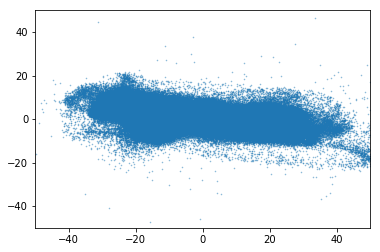

In [22]:
plt.scatter(Y_disk_690,Z_disk_690, s=0.3,alpha=0.5)
plt.xlim(-50,50)
plt.ylim(-50,50)

In [23]:
disk_pos_690 = np.zeros((len(X_disk_690),3))
disk_pos_690[:,0] = X_disk_690
disk_pos_690[:,1] = Y_disk_690
disk_pos_690[:,2] = Z_disk_690

bulg_pos_690 = np.zeros((len(X_bulg_690),3))
bulg_pos_690[:,0] = X_bulg_690
bulg_pos_690[:,1] = Y_bulg_690
bulg_pos_690[:,2] = Z_bulg_690

dm_pos_690 = np.zeros((len(X_dm_690),3))
dm_pos_690[:,0] = X_dm_690
dm_pos_690[:,1] = Y_dm_690
dm_pos_690[:,2] = Z_dm_690

disk_vel_690 = np.zeros((len(U_disk_690),3))
disk_vel_690[:,0] = U_disk_690
disk_vel_690[:,1] = V_disk_690
disk_vel_690[:,2] = W_disk_690

bulg_vel_690 = np.zeros((len(U_bulg_690),3))
bulg_vel_690[:,0] = U_bulg_690
bulg_vel_690[:,1] = V_bulg_690
bulg_vel_690[:,2] = W_bulg_690

dm_vel_690 = np.zeros((len(U_dm_690),3))
dm_vel_690[:,0] = U_dm_690
dm_vel_690[:,1] = V_dm_690
dm_vel_690[:,2] = W_dm_690

In [24]:
agama.setUnits(mass=1, length=1, velocity=1)

dark = agama.Potential(type = "Multipole",particles=(dm_pos_690, dm_mass_690),symmetry='a', gridsizeR=20, lmax=2)

disk = agama.Potential(type = "CylSpline",particles=(disk_pos_690, disk_mass_690),gridsizeR=20, gridsizeZ=20,
                        mmax=0, Rmin=0.1, symmetry='a',Rmax=70, Zmin=0.02, Zmax=30)
                       
bulge = agama.Potential(type = "Multipole",particles=(bulg_pos_690, bulg_mass_690),symmetry='a',gridsizeR=20,lmax=2)

In [25]:
potential = agama.Potential(dark, disk, bulge)
af = agama.ActionFinder(potential, interp=False)

In [26]:
bulgepoints_690 = np.hstack((bulg_pos_690,bulg_vel_690))
diskpoints_690 = np.hstack((disk_pos_690,disk_vel_690))
dmpoints_690 = np.hstack((dm_pos_690,dm_vel_690))

Bulg_actions_690, Bulg_angles_690, Bulg_freq_690 = af(bulgepoints_690, angles=True)
Disk_actions_690, Disk_angles_690, Disk_freq_690 = af(diskpoints_690, angles=True)
DM_actions_690, DM_angles_690, DM_freq_690 = af(dmpoints_690, angles=True)

In [27]:
Jrdisk_690 = Disk_actions_690[:, 0]
Jzdisk_690 = Disk_actions_690[:, 1]
Jphidisk_690 = Disk_actions_690[:, 2]

Jrbulg_690 = Bulg_actions_690[:, 0]
Jzbulg_690 = Bulg_actions_690[:, 1]
Jphibulg_690 = Bulg_actions_690[:, 2]

Jrdm_690 = DM_actions_690[:, 0]
Jzdm_690 = DM_actions_690[:, 1]
Jphidm_690 = DM_actions_690[:, 2]

Trdisk_690 = Disk_angles_690[:, 0]
Tzdisk_690 = Disk_angles_690[:, 1]
Tphidisk_690 = Disk_angles_690[:, 2]

Trbulg_690 = Bulg_angles_690[:, 0]
Tzbulg_690 = Bulg_angles_690[:, 1]
Tphibulg_690 = Bulg_angles_690[:, 2]

Trdm_690 = DM_angles_690[:, 0]
Tzdm_690 = DM_angles_690[:, 1]
Tphidm_690 = DM_angles_690[:, 2]

Ordisk_690 = Disk_freq_690[:, 0]
Ozdisk_690 = Disk_freq_690[:, 1]
Ophidisk_690 = Disk_freq_690[:, 2]

Orbulg_690 = Bulg_freq_690[:, 0]
Ozbulg_690 = Bulg_freq_690[:, 1]
Ophibulg_690 = Bulg_freq_690[:, 2]

Ordm_690 = DM_freq_690[:, 0]
Ozdm_690 = DM_freq_690[:, 1]
Ophidm_690 = DM_freq_690[:, 2]

In [28]:
c1 = fits.Column(name='Jr', array=np.array(Jrdisk_690), format='D', unit = 'kpc2 Myr-1')
c2 = fits.Column(name='Jphi', array=np.array(Jphidisk_690), format='D', unit = 'kpc2 Myr-1')
c3 = fits.Column(name='Jz', array=np.array(Jzdisk_690), format='D', unit ='kpc2 Myr-1')
c4 = fits.Column(name='Theta_r', array=np.array(Trdisk_690), format='D', unit = 'rad')
c5 = fits.Column(name='Theta_phi', array=np.array(Tphidisk_690), format='D', unit = 'rad')
c6 = fits.Column(name='Theta_z', array=np.array(Tzdisk_690), format='D', unit='rad')
c7 = fits.Column(name='Freq_r', array=np.array(Ordisk_690), format='D', unit='Myr-1')
c8 = fits.Column(name='Freq_phi', array=np.array(Ophidisk_690), format='D',unit='Myr-1')
c9 = fits.Column(name='Freq_z', array=np.array(Ozdisk_690), format='D', unit='Myr-1')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8, c9])

t.writeto('DiskActions_690.fits')

In [29]:
c1 = fits.Column(name='X', array=np.array(disk_pos_690[:,0]), format='D', unit = 'kpc')
c2 = fits.Column(name='Y', array=np.array(disk_pos_690[:,1]), format='D', unit = 'kpc')
c3 = fits.Column(name='Z', array=np.array(disk_pos_690[:,2]), format='D', unit ='kpc')
c4 = fits.Column(name='U', array=np.array(disk_vel_690[:,0]), format='D', unit = 'km/s')
c5 = fits.Column(name='V', array=np.array(disk_vel_690[:,1]), format='D', unit = 'km/s')
c6 = fits.Column(name='W', array=np.array(disk_vel_690[:,2]), format='D', unit='km/s')
c7 = fits.Column(name='Mass', array=np.array(disk_mass_690), format='D', unit='Solar Mass')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7])

t.writeto('PhaseSpaceDisk_690.fits')